In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
# import ipynb_importer
# import utils

In [2]:
transform = transforms.Compose([
#     transforms.Resize(196),
#     transforms.CenterCrop(224),
    transforms.ToTensor()
])

train = torchvision.datasets.MNIST(root='./', train=True, transform=transform, download=True)
test = torchvision.datasets.MNIST(root='./', train=False, transform=transform, download=True)
# train.data = train.data.float() / 255.0
# train.data = (train.data - torch.mean(train.data, dim=(1,2), keepdim=True)) / torch.std(train.data, dim=(1,2), keepdim=True)
# test.data = test.data / 255.0

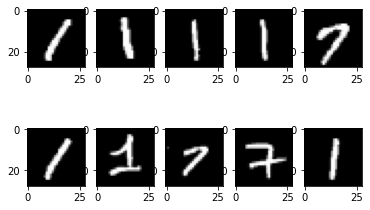

In [3]:
def binary_class(data, classes):
    # classes is a list of two numbers
    idx = torch.where(torch.isin(data.targets, torch.Tensor(classes)))[0]
    idx_1 = torch.where(data.targets[idx] == classes[0])[0]
    idx_2 = torch.where(data.targets[idx] == classes[1])[0]
    binary_labels = torch.zeros(len(idx))
    binary_labels[idx_2] = 1.0
    dataset = torch.utils.data.TensorDataset(data.data[idx] / 255.0, binary_labels)
    dataset.data = data.data[idx] / 255.0
    return dataset, idx_1, idx_2

classes = [1,7]
train_binary, idx_1, idx_2 = binary_class(train, classes)
test_binary,_,_ = binary_class(test, classes)

# sanity check: input data
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_binary[i][0], cmap='gray')

batch_size = 10
# Dataloader
trainloader_binary = torch.utils.data.DataLoader(train_binary, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_binary = torch.utils.data.DataLoader(test_binary, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
# model architecture
M = len(torch.flatten(train[0][0]))
n1 = 16
n1_junk = 64
n2 = 16
n_classes = 10
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
from torch import nn
import torch.nn.functional as F

In [5]:
w1 = torch.load('w1s_16.pt').data
# print(w1)
k = int(M/n1)
flat = torch.flatten(train_binary.data.float(), start_dim=1)*w1.to('cpu')
weight = torch.reshape(torch.ones(k), (1,1,-1))
lambda_1 = torch.mean(F.relu(F.conv1d(torch.unsqueeze(flat, 1), weight, stride=k)), dim=0)
print(lambda_1)

tensor([[1.5374e-04, 2.6653e-03, 1.7035e-01, 2.3957e-01, 6.4856e-01, 1.8153e+00,
         1.5826e+00, 2.8170e+00, 1.0077e+00, 2.2351e+00, 6.5270e-01, 1.5948e+00,
         1.0969e+00, 1.8866e+00, 9.7085e-01, 5.1440e-01]])


In [6]:
class modulator_two_layers(torch.nn.Module):
    # allow the flexibility of adding junk neurons
    # allow the flexibility of weight correction
    def __init__(self, n1, w1, n2, a2_cont, lr_a2,
                 m, sigma_m, T, tanh_k, a_cont, lr_a, sigma_w, sigma_s, device='cpu',
                 junk=False, junk_mean=None, sigma_junk=None, n1_junk=None, correction=True):
        # m is of size (batch)
        super().__init__()
        self.n1 = n1
        self.w1 = w1
        self.m = m
        self.sigma_m = sigma_m
        self.T = T
        self.tanh_k = tanh_k
        self.a_cont = a_cont
        self.lr_a = lr_a
        self.device = device
        self.junk = junk
        self.n2 = n2
        self.a2_cont = a2_cont
        self.lr_a2 = lr_a2
        if junk:
            self.n1_junk = n1_junk
            self.junk_mean = junk_mean
            self.sigma_junk = sigma_junk
            self.n1_actual = n1 + n1_junk
        else:
            self.n1_actual = n1
        w = torch.Tensor(self.n1_actual).to(device)
        s = torch.Tensor(self.n1).to(device)
        s2 = torch.Tensor(self.n2).to(device)
        self.w = torch.nn.Parameter(w, requires_grad=True)
        self.s = torch.nn.Parameter(s)
        self.s2 = torch.nn.Parameter(s2)
        torch.nn.init.normal_(self.w, 0, sigma_w)
        torch.nn.init.normal_(self.s, 0, sigma_s)
        torch.nn.init.normal_(self.s2, 0, sigma_s)
        self.count = 0

    def forward(self, x):
        k = int(len(self.w1)/self.n1)
        batch = x.size()[0]
        weight = torch.reshape(torch.ones(k), (1,1,-1)).to(device)
        x = F.conv1d(torch.unsqueeze(torch.flatten(x, start_dim=1)*w1,1), weight, stride=k)
        x = torch.squeeze(x, 1)
        x = F.relu(x)
        lambda_1 = x
        if junk:
            x = torch.cat((x, torch.normal(self.junk_mean, self.sigma_junk, size=(x.size()[0],self.n1_junk)).to(device)),
                         dim=1)
        if correction:
            fluc = torch.exp(torch.outer(self.m, self.w) - self.sigma_m*self.sigma_m*self.w*self.w/2.0) # (T, num_neurons)
        else:
            fluc = torch.exp(torch.outer(self.m, self.w))
        k = torch.mul(torch.unsqueeze(x, dim=0), torch.unsqueeze(fluc, dim=1)) # (T, batch, num_neurons)
        a = torch.sum(torch.mul(torch.reshape(self.m, (-1,1,1)), k), dim=0) / self.T # (batch, num_neurons)
#         print(a)
        a = self.lr_a * a + (1-self.lr_a) * self.a_cont
        if self.count > 10000:
#             tanh_k_ = self.tanh_k * np.log(self.count)
            tanh_k_ = 1000.0 # an arbitrary large number
        else:
            tanh_k_ = self.tanh_k
        sign = torch.mean(torch.abs(torch.tanh(tanh_k_ * self.s.data)))*torch.ones(self.n1_actual).to(device)
        sign[:self.n1] = torch.tanh(tanh_k_ * self.s)
        # one sample can only compute the gradient once
        k2 = torch.sum(torch.reshape(sign * a * k, (self.T, batch, self.n2, -1)), dim=-1) # (T, batch, n2)
        a2 = torch.sum(torch.mul(torch.reshape(self.m, (-1,1,1)), k2), dim=0) / self.T # (batch, n2)
        a2 = self.lr_a2 * a2 + (1-self.lr_a2) * self.a2_cont 
        sign2 = torch.tanh(tanh_k_ * self.s2)
        x = torch.sum(sign2 * a2 * torch.mean(k2, dim=0), dim=1) # (batch)
        x = torch.sigmoid(x)
        self.a_cont = torch.mean(a, dim=0).data
        self.a2_cont = torch.mean(a2, dim=0).data
        self.count += x.size()[0]
        var2 = torch.mean(torch.var(k2, dim=0), dim=0)
        return x, lambda_1, torch.mean(k2, dim=0), torch.mean(a, dim=0), torch.mean(a2, dim=0), var2

In [7]:
import copy

def training_corr(model, dataloader, optimizer, criterion, num_epoch=10, device='cpu', binary=False):
    model.to(device)
    model.train()
    accuracy = []
    correlation_w = [0]
    correlation_a = [0]
    correlation_a2 = [0]
    correlation_var2 = [0]
    signs = []
    signs2 = []
    modulation_weights = []
    dp = []
    sum1_1 = torch.zeros(n1).to(device)
    sum1_2 = torch.zeros(n1).to(device)
    ss1_1 = torch.zeros(n1).to(device)
    ss1_2 = torch.zeros(n1).to(device)
    sum2_1 = torch.zeros(n2).to(device)
    sum2_2 = torch.zeros(n2).to(device)
    ss2_1 = torch.zeros(n2).to(device)
    ss2_2 = torch.zeros(n2).to(device)
    count1 = 0
    count2 = 0
    dummy = torch.empty((2, n1)).to(device)
    dummy2 = torch.empty((2, n2)).to(device)
    correct = 0
    total = 0
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = torch.squeeze(torch.flatten(inputs, start_dim=2), dim=1).float()
            
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            output, lambda_1, lambda_2, a, a2, var2 = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            # compute the correlation between d' and w
            idx1 = torch.where(labels==0)[0]
            idx2 = torch.where(labels==1)[0]
            count1 += len(idx1)
            count2 += len(idx2)
#             k1_1 = F.relu(F.conv1d(torch.unsqueeze(torch.flatten(inputs[idx1], start_dim=1)*w1,1), weight, stride=k))
#             k1_2 = F.relu(F.conv1d(torch.unsqueeze(torch.flatten(inputs[idx2], start_dim=1)*w1,1), weight, stride=k))            
            sum1_1 += torch.sum(lambda_1[idx1], dim=0)
            sum1_2 += torch.sum(lambda_1[idx2], dim=0)
            ss1_1 += torch.sum(lambda_1[idx1]*lambda_1[idx1], dim=0)
            ss1_2 += torch.sum(lambda_1[idx2]*lambda_1[idx2], dim=0)
            mean1_1 = sum1_1 / count1
            mean1_2 = sum1_2 / count2            
            sd1_1 = ss1_1/count1 - mean1_1*mean1_1
            sd1_2 = ss1_2/count2 - mean1_2*mean1_2
            sum2_1 += torch.sum(lambda_2[idx1], dim=0)
            sum2_2 += torch.sum(lambda_2[idx2], dim=0)
            ss2_1 += torch.sum(lambda_2[idx1]*lambda_2[idx1], dim=0)
            ss2_2 += torch.sum(lambda_2[idx2]*lambda_2[idx2], dim=0)
            mean2_1 = sum2_1 / count1
            mean2_2 = sum2_2 / count2            
            sd2_1 = ss2_1/count1 - mean2_1*mean2_1
            sd2_2 = ss2_2/count2 - mean2_2*mean2_2
            d1_prime = torch.abs(mean1_1-mean1_2)/(torch.sqrt(sd1_1*sd1_1+sd1_2*sd1_2) / 2.0 + 0.001)
            d2_prime = torch.abs(mean2_1-mean2_2)/(torch.sqrt(sd2_1*sd2_1+sd2_2*sd2_2) / 2.0 + 0.001)
            
            w = copy.deepcopy(list(model.parameters())[0].data)
            dummy[0] = d1_prime
            dummy[1] = w[:n1]
            correlation_w.append(torch.corrcoef(dummy)[0,1])
            dummy[1] = torch.abs(a[:n1])
            correlation_a.append(torch.corrcoef(dummy)[0,1])
            dummy2[0] = d2_prime
            dummy2[1] = torch.abs(a2[:n1])
            correlation_a2.append(torch.corrcoef(dummy2)[0,1])
            dummy2[1] = var2
            correlation_var2.append(torch.corrcoef(dummy2)[0,1])
            
            
            # check parameters in the training process
            s = copy.deepcopy(list(model.parameters())[1].data)
            modulation_weights.append(w)
            signs.append(s)
            s2 = copy.deepcopy(list(model.parameters())[2].data)
            signs2.append(s2)
#             dp.append(d_prime)


            # print statistics
            running_loss += loss.item()
            if binary:
                predicted = torch.where(output.data < 0.5, 0, 1)
            else:
                _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy.append(correct/total)
        print('(Epoch %d) loss: %.3f, accuracy: %.3f'%(epoch, running_loss/total, correct/total))
    return model, accuracy, correlation_w, correlation_a, correlation_a2, correlation_var2, modulation_weights, signs, signs2

In [17]:
sigma_w = 0.3
sigma_s = 0.02
sigma_m = 0.1
# m_mean = 0.5
m_mean = 1.0
# T = 50
T = 200
m = torch.normal(m_mean, sigma_m, size=(T,))
m = m.to(device)
lr_a = 0.1
lr_a2 = 0.1
tanh_k = 10.0
# tanh_k = 50.0
junk = True
junk_mean = torch.mean(lambda_1).item()
# junk_mean = 0.0
sigma_junk = torch.std(lambda_1).item()
if junk:
    a_cont = torch.normal(0, 0.1, size=(n1 + n1_junk,))
else:
    a_cont = torch.normal(0, 0.1, size=(n1,))
a_cont = a_cont.to(device)
a2_cont = torch.normal(0, 0.1, size=(n2, ))
a2_cont = a2_cont.to(device)
correction = True

# model_modulator_one = modulator_one_layer(n1, w1, m, sigma_m, T, tanh_k, a_cont, lr_a, sigma_w, sigma_s, device=device,
#                  junk=junk, junk_mean=junk_mean, sigma_junk=sigma_junk, n1_junk=n1_junk, correction=correction)

k = int(len(w1)/n1)
weight = torch.reshape(torch.ones(k), (1,1,-1)).to(device)
w1 = w1.to(device)
num_epoch = 2

num_rep = 10
accuracy_modulator_two = []
correlation_w = []
correlation_a = []
correlation_a2 = []
correlation_var2 = []
modulator_weights = []
signs = []
signs2 = []
for i in range(num_rep):
    model_modulator_two = modulator_two_layers(n1, w1, n2, a2_cont, lr_a2, m, sigma_m, T, tanh_k, a_cont, lr_a, 
                                              sigma_w, sigma_s, device=device,
                 junk=junk, junk_mean=junk_mean, sigma_junk=sigma_junk, n1_junk=n1_junk, correction=correction)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam([{'params': list(model_modulator_two.parameters())[0], 'lr':0.01},
                              {'params': list(model_modulator_two.parameters())[1]},
                                 {'params': list(model_modulator_two.parameters())[2]}])
    model_modulator_two, acc, corr_w, corr_a, corr_a2, corr_var2, w, s, s2 = \
    training_corr(model_modulator_two, trainloader_binary, 
                              optimizer, criterion, num_epoch=num_epoch, device=device, binary=True)
    accuracy_modulator_two.append(acc)
    correlation_w.append(corr_w)
    correlation_a.append(corr_a)
    correlation_a2.append(corr_a2)
    correlation_var2.append(corr_var2)
    modulator_weights.append(w)
    signs.append(s)
    signs2.append(s2)

(Epoch 0) loss: 0.070, accuracy: 0.974
(Epoch 1) loss: 0.111, accuracy: 0.974
(Epoch 0) loss: 0.051, accuracy: 0.955
(Epoch 1) loss: 0.042, accuracy: 0.971
(Epoch 0) loss: 0.076, accuracy: 0.964
(Epoch 1) loss: 0.072, accuracy: 0.972
(Epoch 0) loss: 0.072, accuracy: 0.971
(Epoch 1) loss: 0.065, accuracy: 0.977
(Epoch 0) loss: 0.064, accuracy: 0.966
(Epoch 1) loss: 0.079, accuracy: 0.969
(Epoch 0) loss: 0.046, accuracy: 0.972
(Epoch 1) loss: 0.071, accuracy: 0.976
(Epoch 0) loss: 0.035, accuracy: 0.972
(Epoch 1) loss: 0.080, accuracy: 0.976
(Epoch 0) loss: 1.073, accuracy: 0.854
(Epoch 1) loss: 2.582, accuracy: 0.669
(Epoch 0) loss: 0.052, accuracy: 0.973
(Epoch 1) loss: 0.058, accuracy: 0.977
(Epoch 0) loss: 0.121, accuracy: 0.939
(Epoch 1) loss: 0.083, accuracy: 0.950


In [9]:
torch.save(accuracy_modulator_two, 'accuracy_modulator_two.pt')
torch.save(correlation_w, 'correlation_w.pt')
torch.save(correlation_a, 'correlation_a.pt')
torch.save(correlation_a2, 'correlation_a2.pt')
torch.save(correlation_var2, 'correlation_var2.pt')
torch.save(modulator_weights, 'modulator_weights_two_layers.pt')
torch.save(signs, 'signs_two_layers.pt')
torch.save(signs2, 'signs2_two_layers.pt')

In [2]:
accuracy_modulator_two = torch.load('accuracy_modulator_two.pt')
correlation_w = torch.load('correlation_w.pt')
correlation_a = torch.load('correlation_a.pt')
correlation_a2 = torch.load('correlation_a2.pt')
correlation_var2 = torch.load('correlation_var2.pt')
modulator_weights = torch.load('modulator_weights_two_layers.pt')
signs = torch.load('signs_two_layers.pt')
signs2 = torch.load('signs2_two_layers.pt')

accuracy_baseline_one = torch.load('accuracy_baseline_one.pt')

In [3]:
def plot_sd(array, axis=0, alpha=0.2, label=None, color='tab:blue', linewidth=1.0):
    # axis: along which array is averaged
    mean = np.mean(array, axis=axis)
    sd = np.std(array, axis=axis)
    plt.plot(mean, label=label, color=color, linewidth=linewidth)
    plt.fill_between(np.arange(len(array[0])), mean-sd, mean+sd, alpha=alpha, color=color)

def unpack_list_of_tensor(l):
    l_new = []
    for i in range(len(l)):
        l_new.append(torch.stack(l[i]))
    return torch.stack(l_new)

def unpack_list_of_list(l):
    l_new = []
    for i in range(len(l)):
        l_new.append(torch.Tensor(l[i]))
    return torch.stack(l_new)

In [4]:
correlation_w_avg = unpack_list_of_list(correlation_w).cpu().numpy()
length = correlation_w_avg.shape[1]
correlation_w_avg = np.divide(np.cumsum(correlation_w_avg, axis=1), np.arange(length)+1)
correlation_a_avg = unpack_list_of_list(correlation_a).cpu().numpy()
correlation_a_avg = np.divide(np.cumsum(correlation_a_avg, axis=1), np.arange(length)+1)
correlation_var2_avg = unpack_list_of_list(correlation_var2).cpu().numpy()
correlation_var2_avg = np.divide(np.cumsum(correlation_var2_avg, axis=1), np.arange(length)+1)
correlation_a2_avg = unpack_list_of_list(correlation_a2).cpu().numpy()
correlation_a2_avg = np.divide(np.cumsum(correlation_a2_avg, axis=1), np.arange(length)+1)

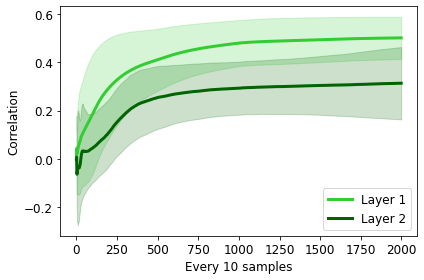

In [32]:
plt.figure(figsize=(6,4))
plot_sd(correlation_w_avg[:,:2000], linewidth=3.0, color='limegreen', label='Layer 1')
# plot_sd(correlation_a_avg, linewidth=3.0, color='mediumpurple')
plot_sd(correlation_var2_avg[:,:2000], linewidth=3.0, color='darkgreen', label='Layer 2')
# plot_sd(correlation_a2_avg, linewidth=3.0, color='purple')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Every 10 samples', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.legend(loc=4, fontsize=12)
plt.tight_layout()
plt.savefig('result_2_correlation.png', transparent=True)

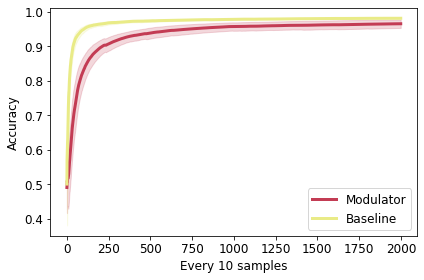

In [7]:
plt.figure(figsize=(6,4))
plot_sd(unpack_list_of_list(accuracy_modulator_two).cpu().numpy()[:,10:2010], color='#C33C54', label='Modulator',
       linewidth=3)
plot_sd(unpack_list_of_list(accuracy_baseline_one).cpu().numpy()[:,:2000], label='Baseline', linewidth=3, color='#E9EB87')
plt.legend(loc=4, prop={'size': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Every 10 samples', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.tight_layout()
plt.savefig('result_2_accuracy.png', transparent=True)

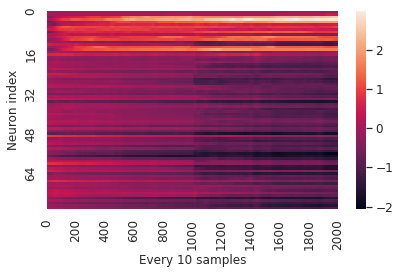

In [37]:
import seaborn as sns
sns.set(font_scale=1.1)
sns.heatmap(unpack_list_of_tensor(modulator_weights)[0,:2001].cpu().numpy().T, xticklabels=200, yticklabels=16)
plt.xlabel('Every 10 samples', fontsize=12)
plt.ylabel('Neuron index', fontsize=12)
plt.tight_layout()
plt.savefig('result_2_weights.png', transparent=True)